# Collaborative Filterting on MovieLens Dataset

In this notebook, I'm making an attempt to "unwrap" abstaction layers of this [fast.ai lecture](http://course.fast.ai/lessons/lesson5.html) where the author is explaining how to use embeddings to build a simple recommendation system.

In other words, I'm going to directly use PyTorch framework to train a small deep learning model to predict user ratings for specific movies. The original lesson's notebook is presented [here](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson5-movielens.ipynb).

> **Note:** The notebook requires Python 3.6 or above. Otherwise, replace `pathlib` objects with plain paths, and interpolated strings with `format()` calls to make it compatible with the older versions of the interpreter.

---
## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [19]:
import io
import os
import math
import copy
import zipfile
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler

In [5]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

In [6]:
RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

---
## Dataset Downloading

In [168]:
def try_download(url, download_path):
    archive_name = url.split('/')[-1]
    folder_name, _ = os.path.splitext(archive_name)
    
    try:
        r = urlopen(url)
    except URLError as e:
        print('Cannot download the data. Error: %s' % s)
        return 

    assert r.status == 200
    data = r.read()

    with zipfile.ZipFile(io.BytesIO(data)) as arch:
        arch.extractall(download_path)

In [169]:
def read_data(path):
    files = {}
    for filename in path.glob('*'):
        if filename.suffix == '.csv':
            files[filename.stem] = pd.read_csv(filename)
        elif filename.suffix == '.dat':
            if filename.stem == 'ratings':
                columns = ['userId', 'movieId', 'rating', 'timestamp']
            else:
                columns = ['movieId', 'title', 'genres']
            data = pd.read_csv(filename, sep='::', names=columns, engine='python')
            files[filename.stem] = data
    return files['ratings'], files['movies']

Available datasets:

* `ml-latest-small`
* `ml-1m`
* `ml-10m`
* `ml-20m`

In [189]:
# pick any other dataset instead
archive_url = f'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
download_path = Path.home() / 'data' / 'movielens'
try_download(archive_url, download_path)

In [190]:
!ls -l $download_path

total 8
drwxrwxr-x 2 ck ck 4096 Aug 10 20:20 ml-1m
drwxrwxr-x 2 ck ck 4096 Aug 10 20:15 ml-latest-small


In [191]:
ratings, movies = read_data(download_path / 'ml-1m')

---
## Dataset Preview

First of all, let's repeat the steps of the lecture where the dataset is loaded and prepared for further analysis.

In [192]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [193]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [194]:
def tabular_preview(ratings, n=15):
    """Creates a cross-tabular view of users vs movies."""
    
    user_groups = ratings.groupby('userId')['rating'].count()
    top_users = user_groups.sort_values(ascending=False)[:15]

    movie_groups = ratings.groupby('movieId')['rating'].count()
    top_movies = movie_groups.sort_values(ascending=False)[:15]

    top = (
        ratings.
        join(top_users, rsuffix='_r', how='inner', on='userId').
        join(top_movies, rsuffix='_r', how='inner', on='movieId'))

    return pd.crosstab(top.userId, top.movieId, top.rating, aggfunc=np.sum)

In [195]:
tabular_preview(ratings, movies)

movieId,110,260,480,589,593,608,1196,1198,1210,1270,1580,2028,2571,2762,2858
userId,,,,,,,,,,,,,,,
889,4.0,4.0,3.0,5.0,5.0,4.0,4.0,NaN,3.0,4.0,3.0,3.0,5.0,NaN,2.0
1015,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0,4.0
1150,2.0,5.0,NaN,2.0,3.0,5.0,4.0,2.0,3.0,2.0,2.0,2.0,1.0,2.0,4.0
1181,3.0,4.0,2.0,5.0,3.0,3.0,4.0,3.0,3.0,3.0,4.0,4.0,5.0,4.0,3.0
1449,3.0,3.0,2.0,2.0,5.0,5.0,3.0,4.0,2.0,2.0,4.0,3.0,4.0,4.0,4.0
1680,1.0,2.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,3.0,4.0,5.0,3.0,5.0,5.0
1941,5.0,5.0,5.0,3.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,5.0,1.0
1980,4.0,4.0,4.0,4.0,5.0,5.0,4.0,5.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0
2063,5.0,4.0,4.0,2.0,5.0,2.0,4.0,4.0,4.0,4.0,3.0,2.0,5.0,4.0,5.0


---
## Dataset Preparation

Next we need a couple of helpers to prepare the data and make it ready for the training loop. The first one was already implemented in the original post:

In [196]:
def create_dataset(ratings):
    unique_users = ratings.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.userId.map(user_to_index)
    
    unique_movies = ratings.movieId.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.movieId.map(movie_to_index)
    
    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]
    
    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_movies), (X, y)

In [197]:
(n, m), (X, y) = create_dataset(ratings)
print(f'Embeddings: {n} users, {m} movies')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 6040 users, 3706 movies
Dataset shape: (1000209, 2)
Target shape: (1000209,)


The second one is a small class that allows to iterate through the dataset one batch after another:

In [198]:
class ReviewsIterator:
    
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

A convenice function `batches` allows us to split the dataset into smaller chunks during training/validation process:

In [199]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1) 

In [200]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[2234, 3808],
        [ 143, 1388],
        [ 849, 4509],
        [2393, 1016]])
tensor([[4.],
        [4.],
        [2.],
        [3.]])


---
## Embeddings

In this secion we're going to create a `nn.Module` for our embedding network. The main difference from the class provided in the original post is that this class is a bit more generic: it allows to create a network of arbirary depth, with or without dropouts.

In [240]:
class EmbeddingNet(nn.Module):
    
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out
    
    def _init(self):
        
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

For example, if we want to create a network with a single hidden layer and dropout, we can use the following code snippet:

In [241]:
EmbeddingNet(n, m, n_factors=150, hidden=100, dropouts=0.5)

EmbeddingNet(
  (u): Embedding(6040, 150)
  (m): Embedding(3706, 150)
  (drop): Dropout(p=0.02)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

If case if something more involved is required, pass a list of values instead:

In [242]:
EmbeddingNet(n, m, n_factors=150, hidden=[100, 200, 300], dropouts=[0.25, 0.5])

EmbeddingNet(
  (u): Embedding(6040, 150)
  (m): Embedding(3706, 150)
  (drop): Dropout(p=0.02)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25)
    (3): Linear(in_features=100, out_features=200, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5)
    (6): Linear(in_features=200, out_features=300, bias=True)
    (7): ReLU()
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

---
## Cyclical Learning Rate (CLR)

One of the `fastai` library features is the cyclical learning rate scheduler. We can implement something similar inheriting the `_LRScheduler` class from the `torch`. Following the [original paper's](https://arxiv.org/abs/1506.01186) pseudocode, this [CLR Keras callback implementation](https://github.com/bckenstler/CLR), and making a couple of adjustments to support [cosine annealing](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.CosineAnnealingLR) with restarts, let's create our own CLR scheduler.

In [243]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):

        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

The scheduler is very similar to [LambdaLR](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.LambdaLR) one but expects a bit different lambda function singautre.

Next let's define scheduling functions which accept current learning rate and epoch, and return the new rate:

In [244]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
            
        return base_lr + delta
        
    return scheduler

In [245]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

To check the correctness of our implementation, let's create a couple of plots visualizing learning rates changes:

In [246]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

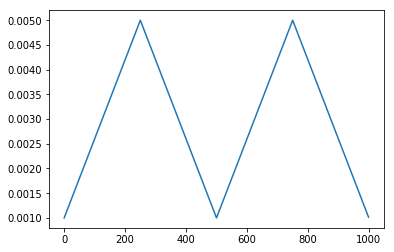

In [247]:
plot_lr(triangular(250, 0.005))

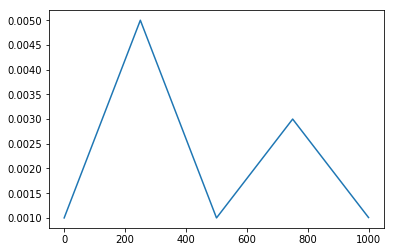

In [248]:
plot_lr(triangular(250, 0.005, 'triangular2'))

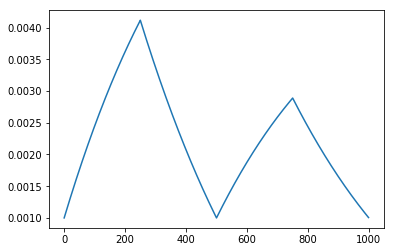

In [249]:
plot_lr(triangular(250, 0.005, 'exp_range', gamma=0.999))

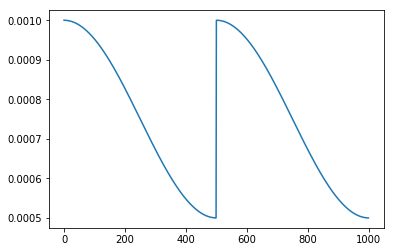

In [250]:
plot_lr(cosine(t_max=500, eta_min=0.0005))

Note that cosine annealing scheduler is a bit different from other schedules as soon as it starts with `base_lr` and gradually decreases it to the minimal value while triangle schedulers increase the original rate.

---
## Training Loop

In [251]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [262]:
minmax = ratings.rating.min().astype(float), ratings.rating.max().astype(float)
minmax

(1.0, 5.0)

In [263]:
net = EmbeddingNet(n, m, n_factors=150, hidden=[500, 500, 500], dropouts=[0.5, 0.5, 0.25])
net

EmbeddingNet(
  (u): Embedding(6040, 150)
  (m): Embedding(3706, 150)
  (drop): Dropout(p=0.02)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25)
  )
  (fc): Linear(in_features=500, out_features=1, bias=True)
)

In [265]:
lr = 1e-3
wd = 1e-5
bs = 1000
n_epochs = 10
best_loss = np.inf
best_weights = None
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
        
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:, 1], x_batch[:, 0], minmax)
                loss = criterion(outputs, y_batch)
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        if phase == 'val' and epoch_loss < best_loss:
            print('loss improvement on epoch: %d' % (epoch + 1))
            best_loss = epoch_loss
            best_weights = copy.deepcopy(net.state_dict())

#     if epoch % 5 == 4:
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))

loss improvement on epoch: 1
[001/010] train: 0.7883 - val: 0.7904
loss improvement on epoch: 2
[002/010] train: 0.7493 - val: 0.7845
loss improvement on epoch: 3
[003/010] train: 0.7548 - val: 0.7807
[004/010] train: 0.7267 - val: 0.7811
[005/010] train: 0.7372 - val: 0.7820
[006/010] train: 0.7066 - val: 0.7837
loss improvement on epoch: 7
[007/010] train: 0.7183 - val: 0.7805
[008/010] train: 0.6823 - val: 0.7875
[009/010] train: 0.6948 - val: 0.7830
[010/010] train: 0.6554 - val: 0.7961


## Metrics

In [ ]:
plt.plot(lr_history[:2*iterations_per_epoch])

In [ ]:
net.load_state_dict(best_weights)

In [ ]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 1], x_batch[:, 0], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [ ]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Final RMSE: {final_loss:.4f}')